In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Enable inline plotting
%matplotlib inline

# Set style for all plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
base_folder = 'C:\\Users\\mvk\\Documents\\DATA_school\\thesis\\data_new'

def load_city_data(base_folder, city, date):
    """Load and preprocess data for a specific city and date."""
    base_path = os.path.join(base_folder, city, date)
    
    # Load data files
    listings = pd.read_csv(f"{base_path}/listings.csv", low_memory=False)
    calendar = pd.read_csv(f"{base_path}/calendar.csv", low_memory=False)
    neighborhoods = pd.read_csv(f"{base_path}/neighbourhoods.csv")
    
    # Clean price columns
    listings['price_clean'] = listings['price'].str.replace('$','').str.replace(',','').astype(float)
    calendar['price_clean'] = calendar['price'].str.replace('$','').str.replace(',','').astype(float)
    calendar['date'] = pd.to_datetime(calendar['date'])
    
    return listings, calendar, neighborhoods

**EDA**

In [3]:
def print_basic_stats(listings, city, date):
    """Print basic statistics about the dataset."""
    print(f"\nBasic Statistics for {city.capitalize()} ({date}):")
    print("-" * 50)
    print(f"Number of listings: {len(listings):,}")
    print(f"Average price: ${listings['price_clean'].mean():.2f}")
    print(f"Median price: ${listings['price_clean'].median():.2f}")
    print(f"Number of neighborhoods: {listings['neighbourhood_cleansed'].nunique()}")
    print("-" * 50)

In [4]:
def plot_price_distributions(listings, city, date):
    """Plot price distribution visualizations."""
    plt.figure(figsize=(15, 5))
    price_data = listings['price_clean'][listings['price_clean'] <= listings['price_clean'].quantile(0.99)]
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=price_data, bins=50)
    plt.title('Price Distribution\n(≤99th percentile)')
    plt.xlabel('Price ($)')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data=price_data, bins=50)
    plt.yscale('log')
    plt.title('Price Distribution (Log Scale)\n(≤99th percentile)')
    plt.xlabel('Price ($)')
    plt.suptitle(f'Price Distributions in {city.capitalize()} ({date})', y=1.05)
    plt.tight_layout()
    plt.show()

In [5]:
def plot_neighborhood_analysis(listings):
    """Plot neighborhood analysis visualizations."""
    plt.figure(figsize=(20, 15))
    neighborhood_stats = listings.groupby('neighbourhood_cleansed').agg({
        'id': 'count',
        'price_clean': 'mean',
        'review_scores_rating': 'mean'
    }).round(2).sort_values('id', ascending=True)
    
    plt.subplot(2, 2, 1)
    neighborhood_stats['id'].plot(kind='barh')
    plt.title('Number of Listings by Neighborhood')
    plt.xlabel('Number of Listings')
    
    plt.subplot(2, 2, 2)
    neighborhood_stats['price_clean'].plot(kind='barh')
    plt.title('Average Price by Neighborhood')
    plt.xlabel('Price ($)')
    
    plt.subplot(2, 2, 3)
    neighborhood_stats['review_scores_rating'].plot(kind='barh')
    plt.title('Average Rating by Neighborhood')
    plt.xlabel('Rating')
    
    plt.subplot(2, 2, 4)
    plt.scatter(neighborhood_stats['review_scores_rating'], 
               neighborhood_stats['price_clean'],
               alpha=0.6)
    plt.xlabel('Rating')
    plt.ylabel('Price ($)')
    plt.title('Price vs Rating by Neighborhood')
    plt.tight_layout()
    plt.show()

In [6]:
def plot_seasonal_patterns(calendar):
    """Plot seasonal pattern visualizations."""
    plt.figure(figsize=(20, 15))
    
    # Daily average prices
    plt.subplot(2, 2, 1)
    daily_avg = calendar.groupby('date')['price_clean'].mean()
    daily_avg.plot()
    plt.title('Daily Average Prices')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    
    # Monthly average prices
    plt.subplot(2, 2, 2)
    monthly_avg = calendar.groupby(calendar['date'].dt.month)['price_clean'].mean()
    monthly_avg.plot(kind='bar')
    plt.title('Monthly Average Prices')
    plt.xlabel('Month')
    plt.ylabel('Price ($)')
    
    # Day of week average prices
    plt.subplot(2, 2, 3)
    dow_avg = calendar.groupby(calendar['date'].dt.day_name())['price_clean'].mean()
    dow_avg.plot(kind='bar')
    plt.title('Average Prices by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    
    # Availability by month
    plt.subplot(2, 2, 4)
    calendar['available'] = calendar['available'].map({'t': 1, 'f': 0})
    monthly_availability = calendar.groupby(calendar['date'].dt.month)['available'].mean() * 100
    monthly_availability.plot(kind='bar')
    plt.title('Monthly Availability')
    plt.xlabel('Month')
    plt.ylabel('Availability (%)')
    plt.tight_layout()
    plt.show()

In [7]:
def plot_room_type_analysis(listings):
    """Plot room type analysis visualizations."""
    plt.figure(figsize=(20, 15))
    
    plt.subplot(2, 2, 1)
    listings['room_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Room Type Distribution')
    
    plt.subplot(2, 2, 2)
    sns.barplot(data=listings, x='room_type', y='price_clean')
    plt.title('Average Price by Room Type')
    plt.xlabel('Room Type')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 3)
    sns.barplot(data=listings, x='room_type', y='review_scores_rating')
    plt.title('Average Rating by Room Type')
    plt.xlabel('Room Type')
    plt.ylabel('Rating')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 4)
    sns.boxplot(data=listings, x='room_type', y='price_clean')
    plt.title('Price Distribution by Room Type')
    plt.xlabel('Room Type')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [8]:
def analyze_reviews_ratings(listings):
    """Plot review scores analysis."""
    plt.figure(figsize=(12, 8))
    review_cols = [col for col in listings.columns if col.startswith('review_scores_')]
    review_corr = listings[review_cols].corr()
    sns.heatmap(review_corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Review Scores')
    plt.tight_layout()
    plt.show()

In [9]:
def create_amenities_analysis(listings):
    """Plot amenities analysis if data is available."""
    if 'amenities' in listings.columns:
        # Process amenities
        try:
            listings['amenities_list'] = listings['amenities'].str.replace('"', '').str.replace("'", '"')
            listings['amenities_list'] = listings['amenities_list'].apply(eval)
        except:
            listings['amenities_list'] = listings['amenities'].str.strip('[]').str.split(',')
        
        listings['amenities_list'] = listings['amenities_list'].apply(
            lambda x: [item.strip().strip('"').strip("'") for item in x if item.strip()]
        )
        
        # Get top amenities
        all_amenities = []
        for amenity_list in listings['amenities_list']:
            all_amenities.extend(amenity_list)
        
        top_amenities = pd.Series(all_amenities).value_counts().head(20)
        
        plt.figure(figsize=(15, 12))
        
        plt.subplot(2, 1, 1)
        sns.barplot(x=top_amenities.values, y=top_amenities.index)
        plt.title('Top 20 Most Common Amenities')
        plt.xlabel('Number of Listings')
        
        # Calculate price impact
        price_impact = []
        amenity_names = []
        
        for amenity in top_amenities.index:
            has_amenity = listings['amenities_list'].apply(lambda x: amenity in x)
            if has_amenity.any() and (~has_amenity).any():
                avg_with = listings[has_amenity]['price_clean'].mean()
                avg_without = listings[~has_amenity]['price_clean'].mean()
                price_impact.append(avg_with - avg_without)
                amenity_names.append(amenity)
        
        plt.subplot(2, 1, 2)
        sns.barplot(x=price_impact, y=amenity_names)
        plt.title('Price Premium for Each Amenity')
        plt.xlabel('Price Difference ($)')
        plt.tight_layout()
        plt.show()



Basic Statistics for Paris (2023-09-04):
--------------------------------------------------
Number of listings: 67,942
Average price: $205.11
Median price: $125.00
Number of neighborhoods: 20
--------------------------------------------------


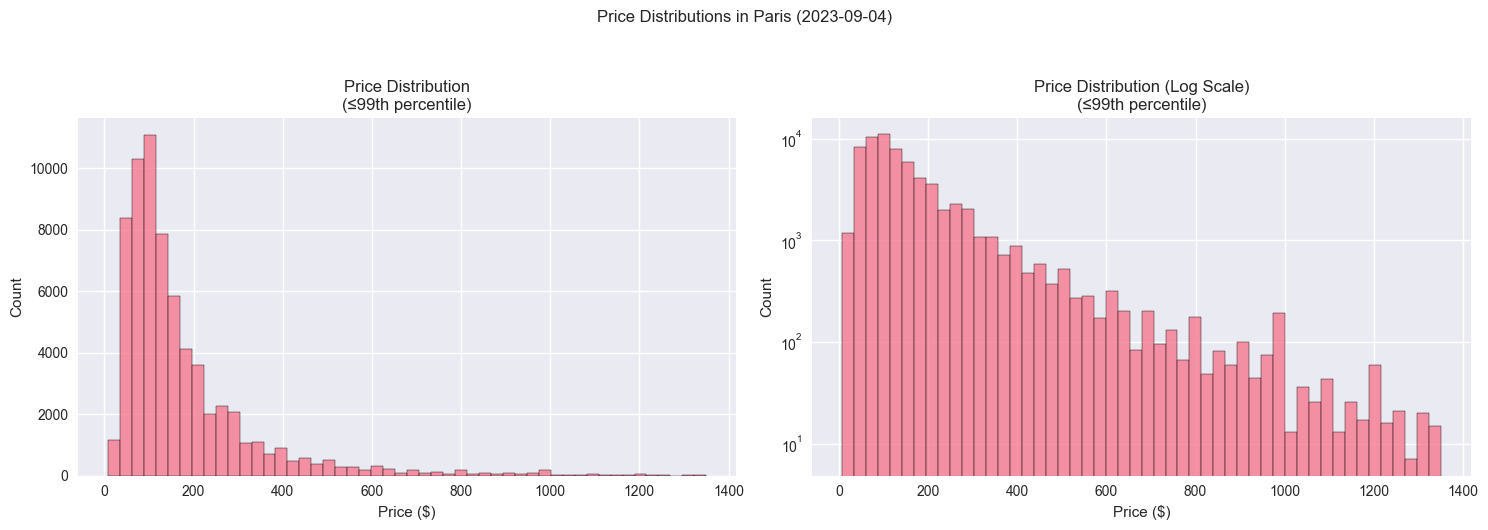

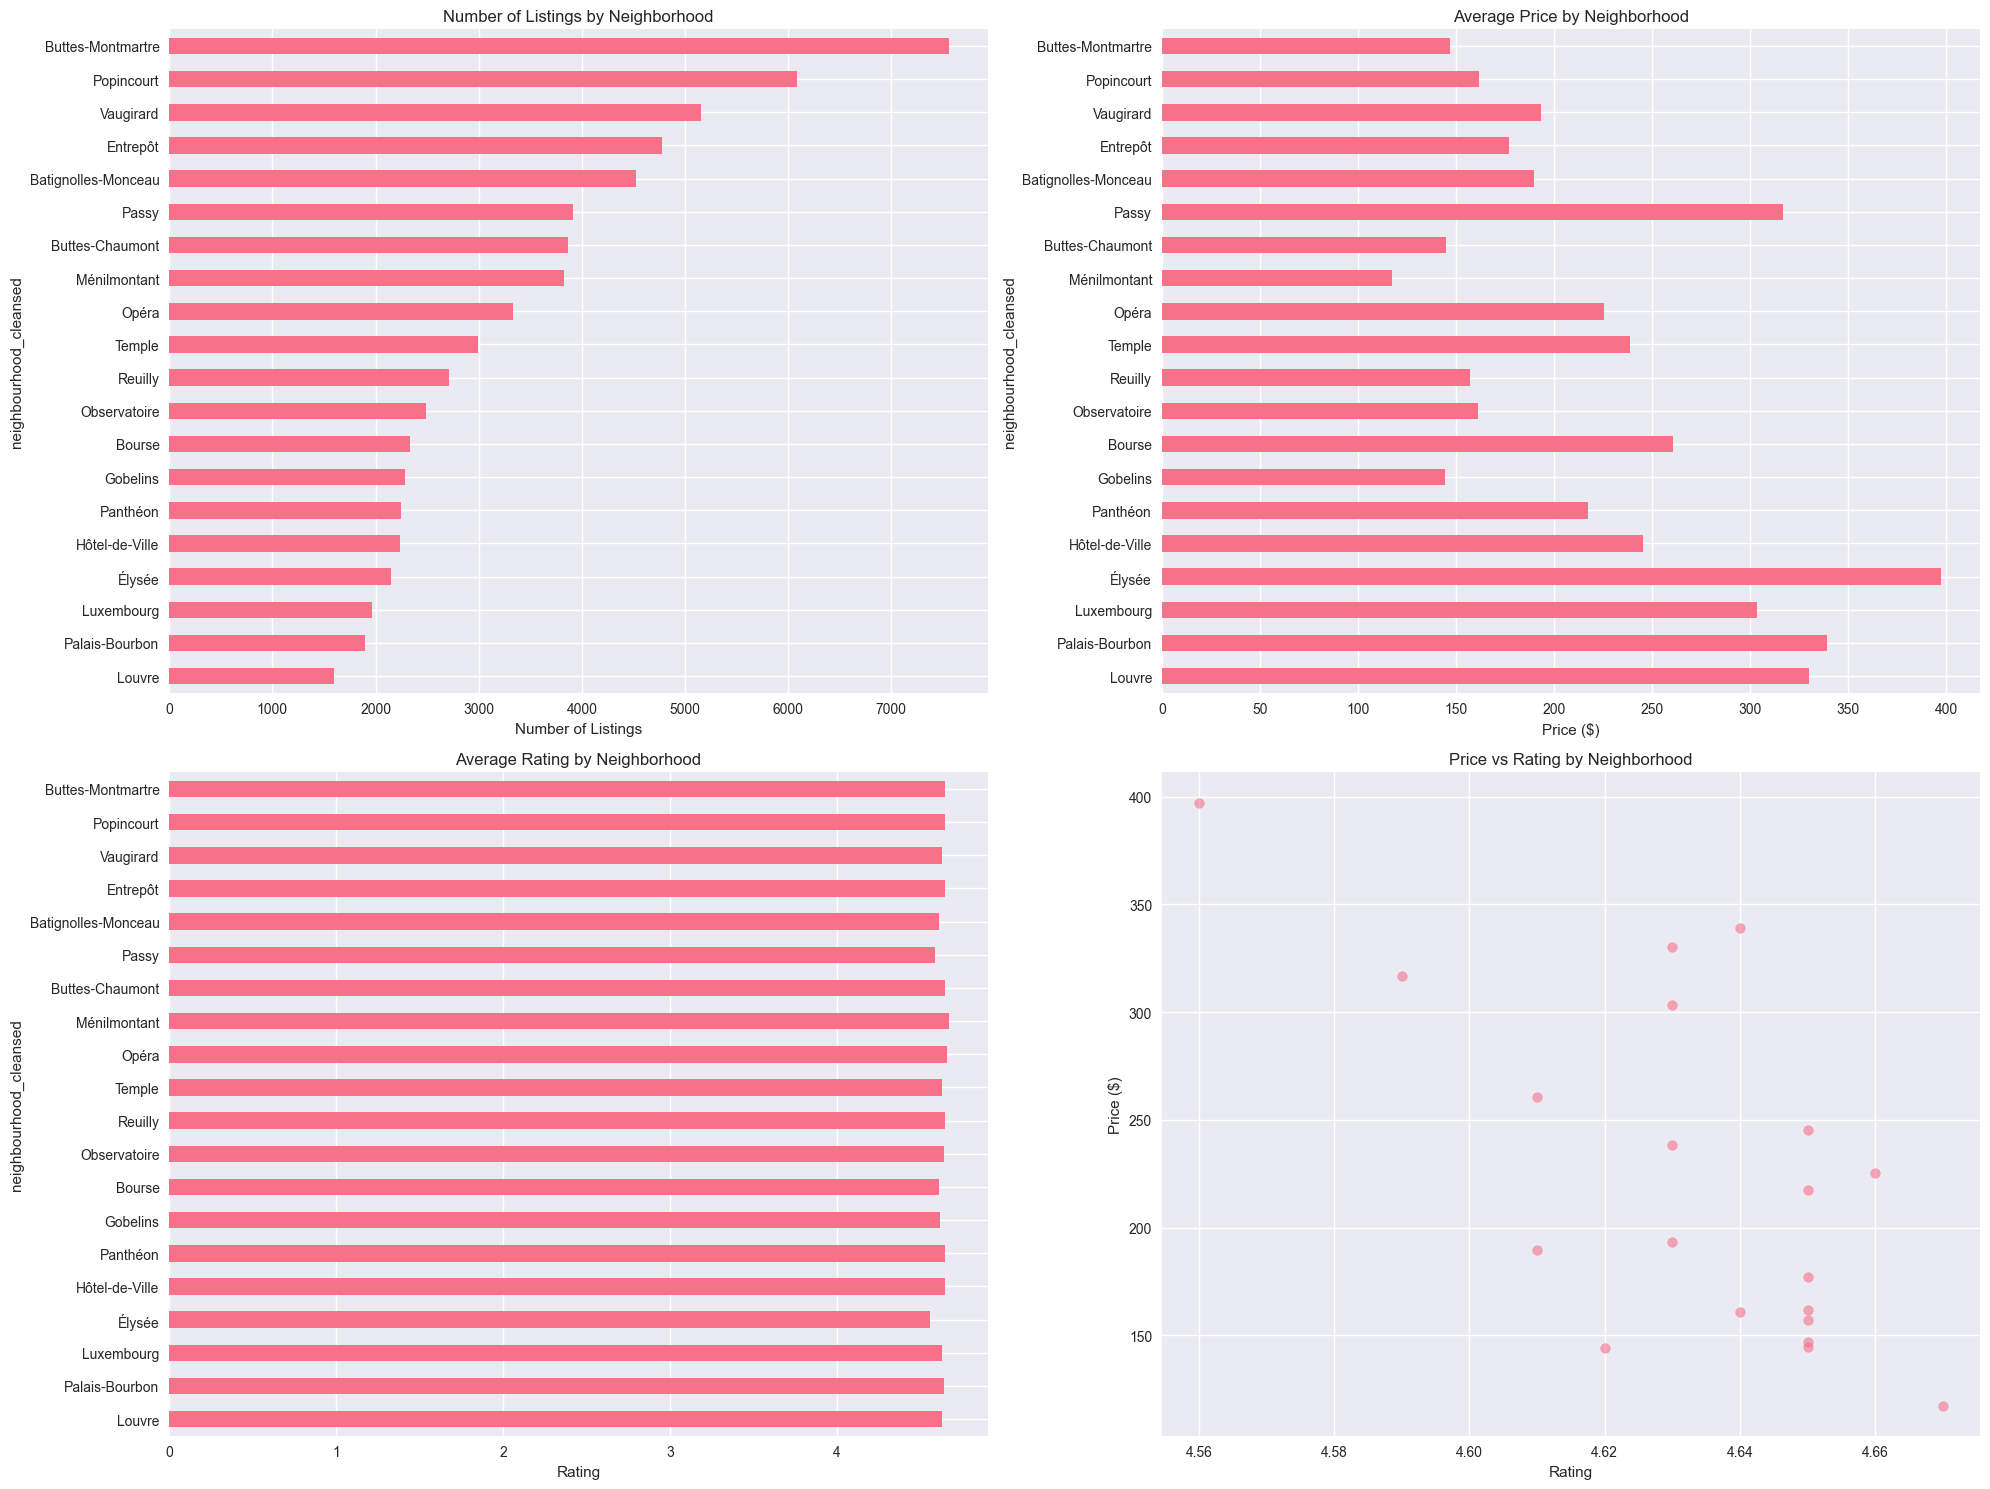

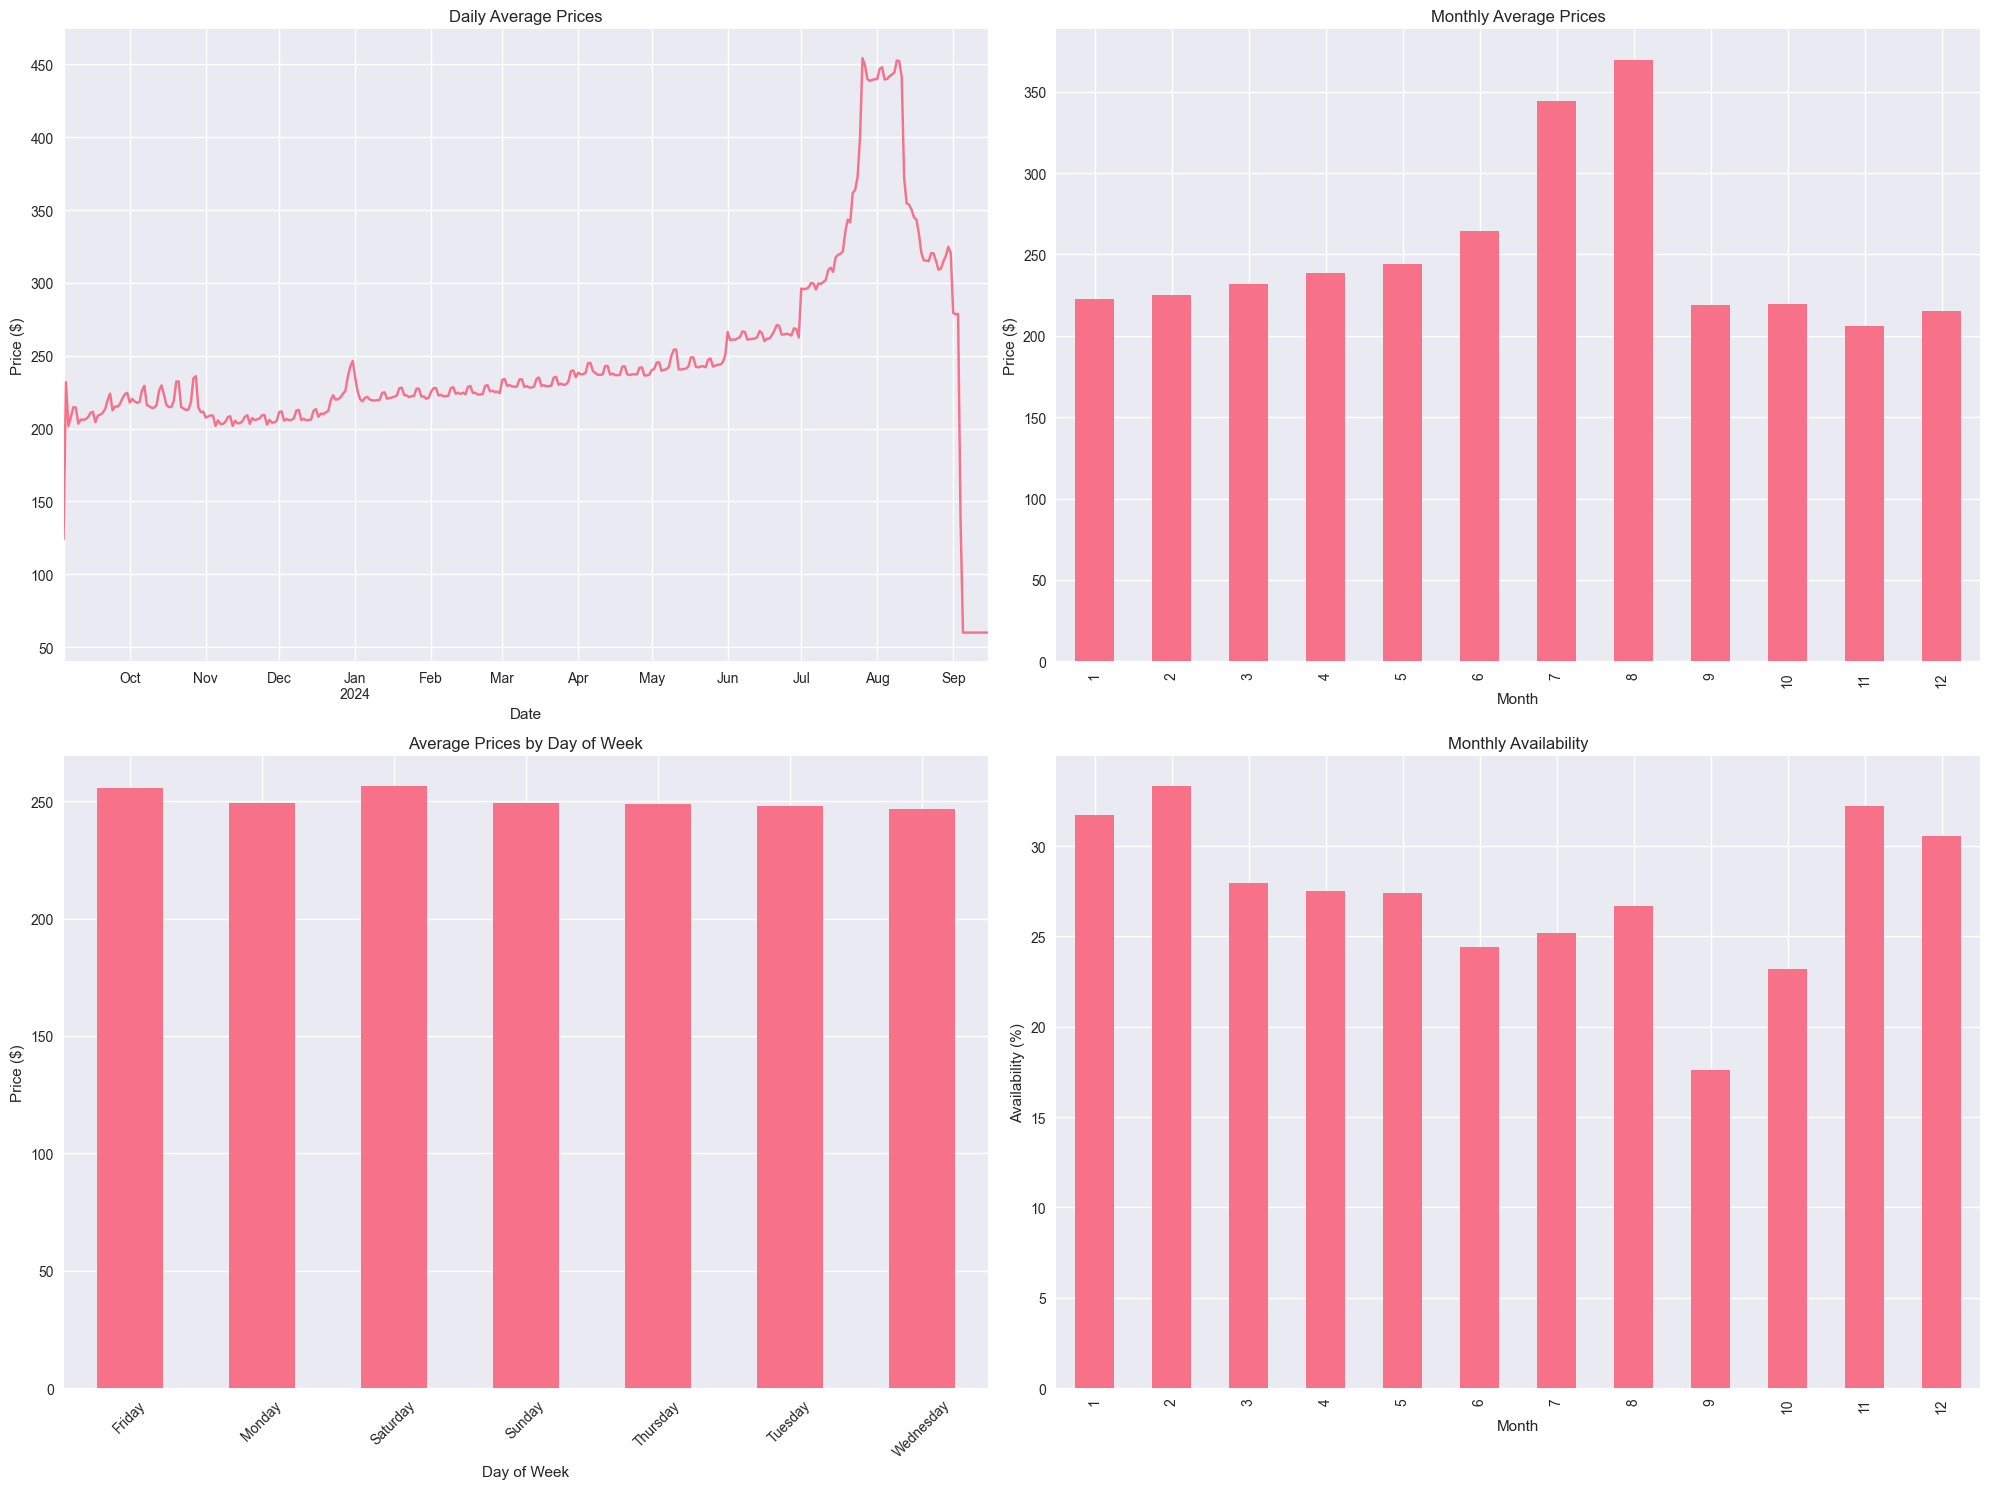

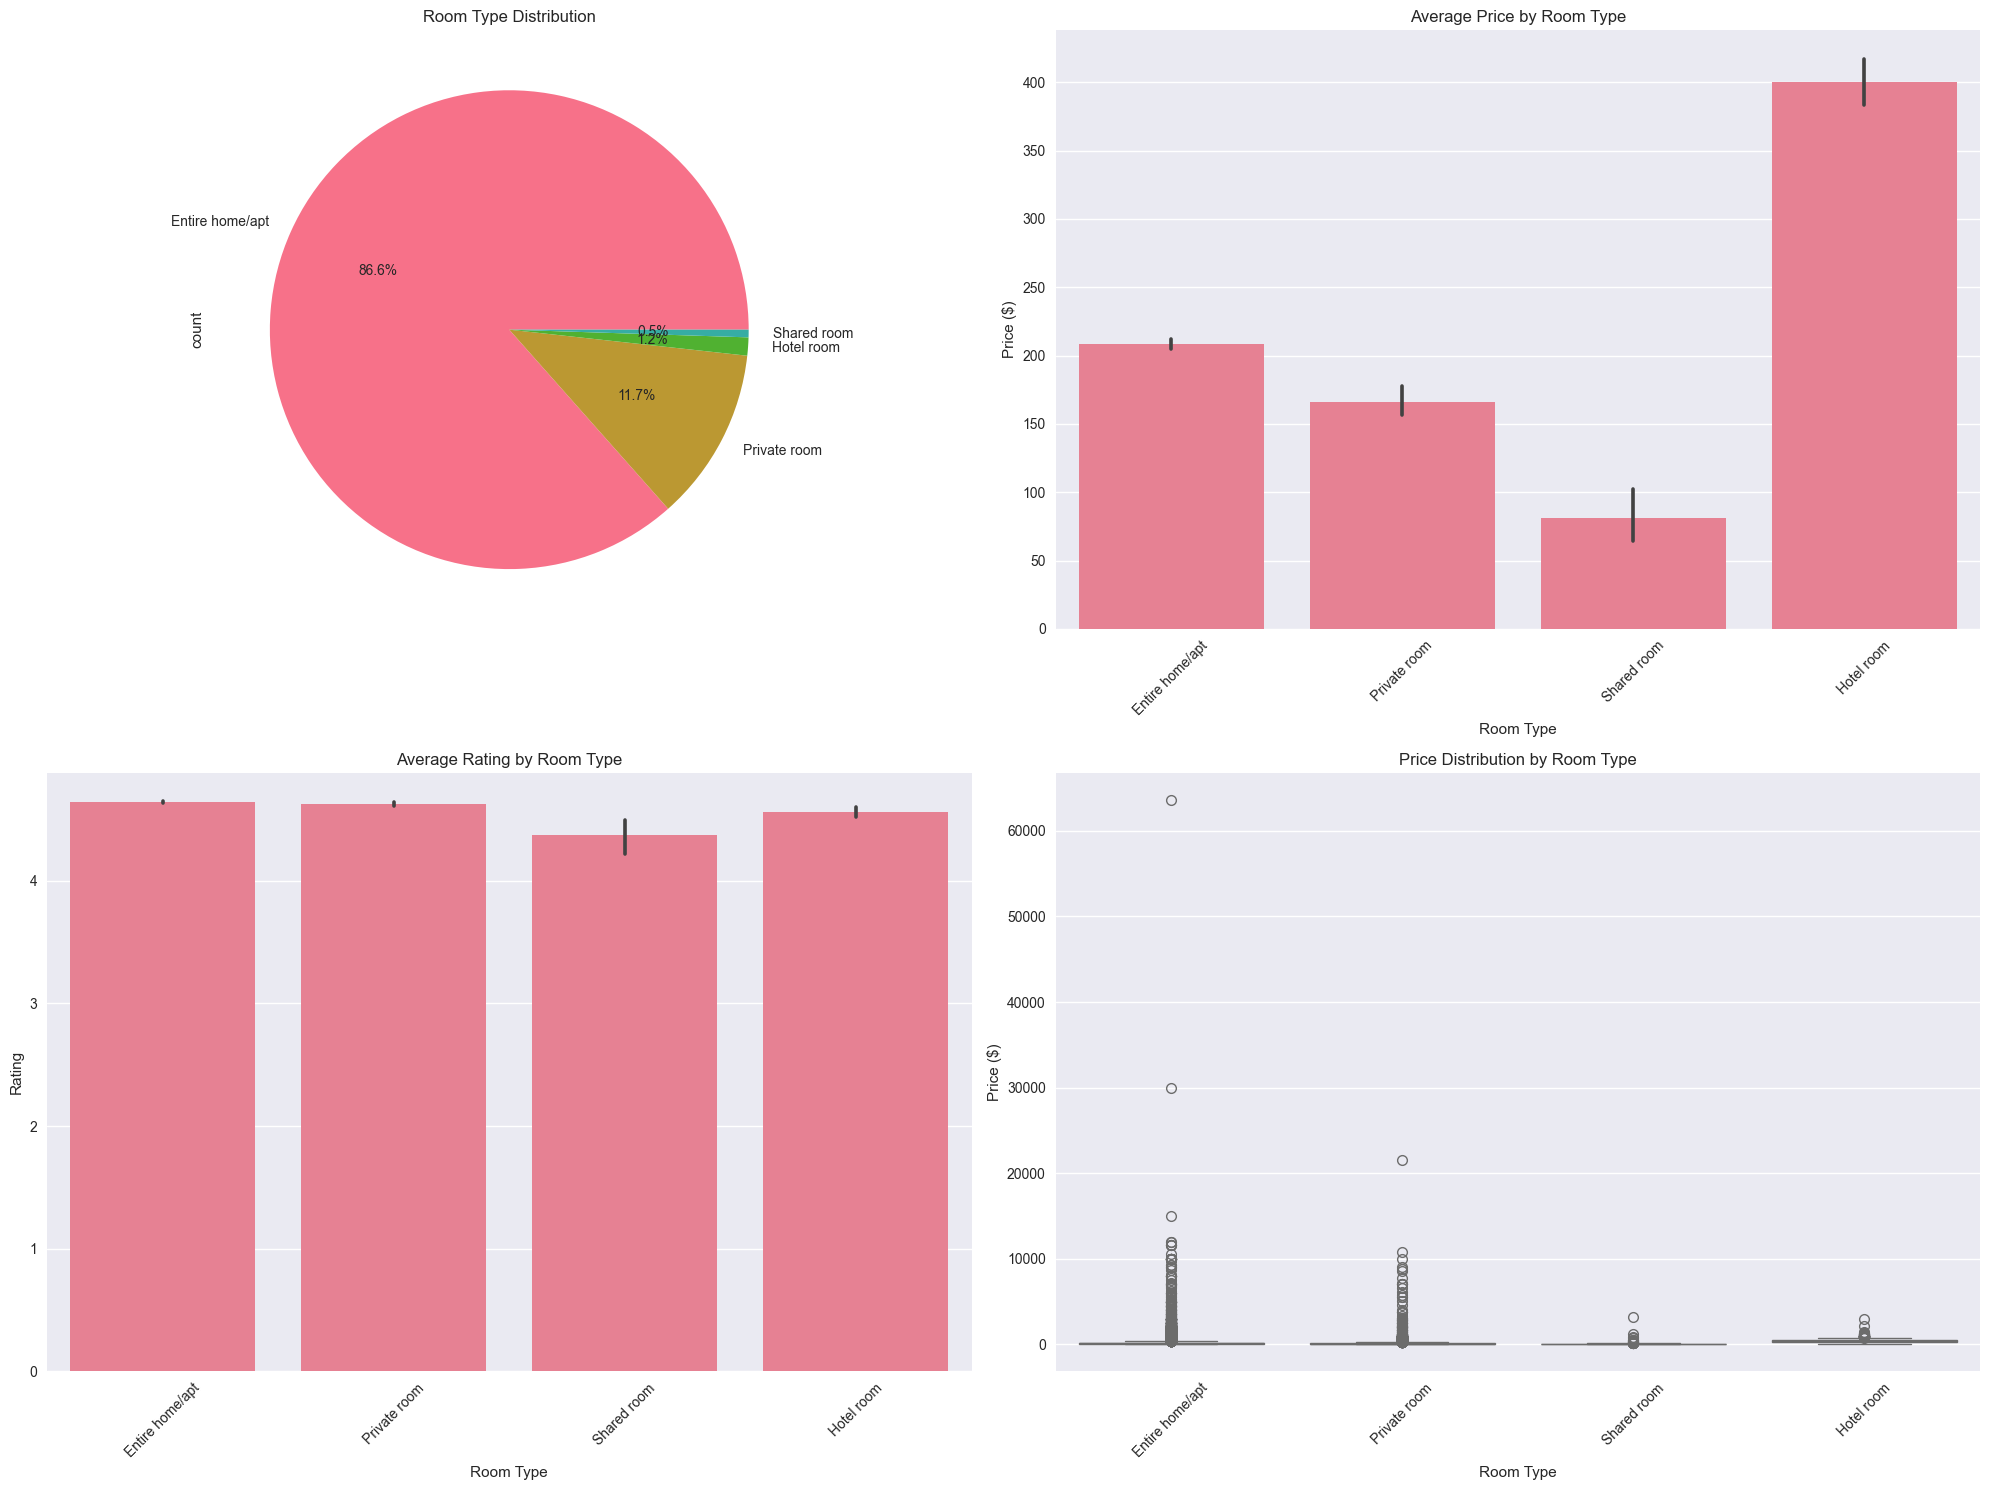

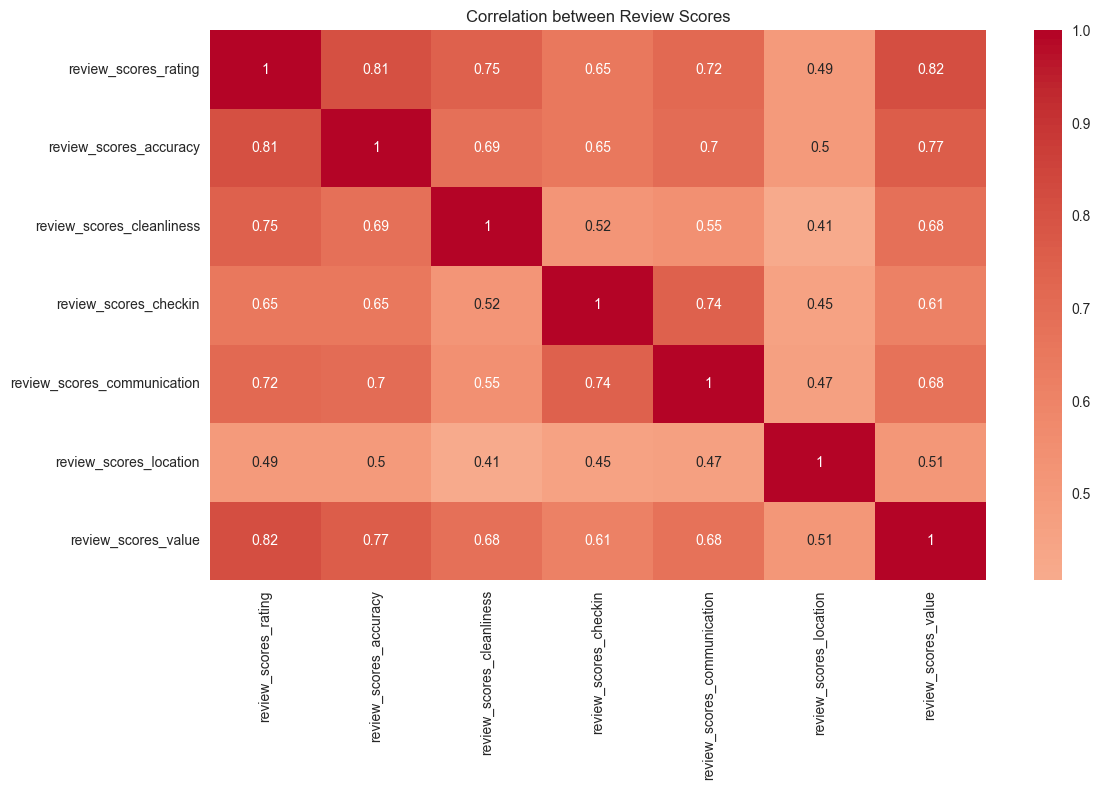

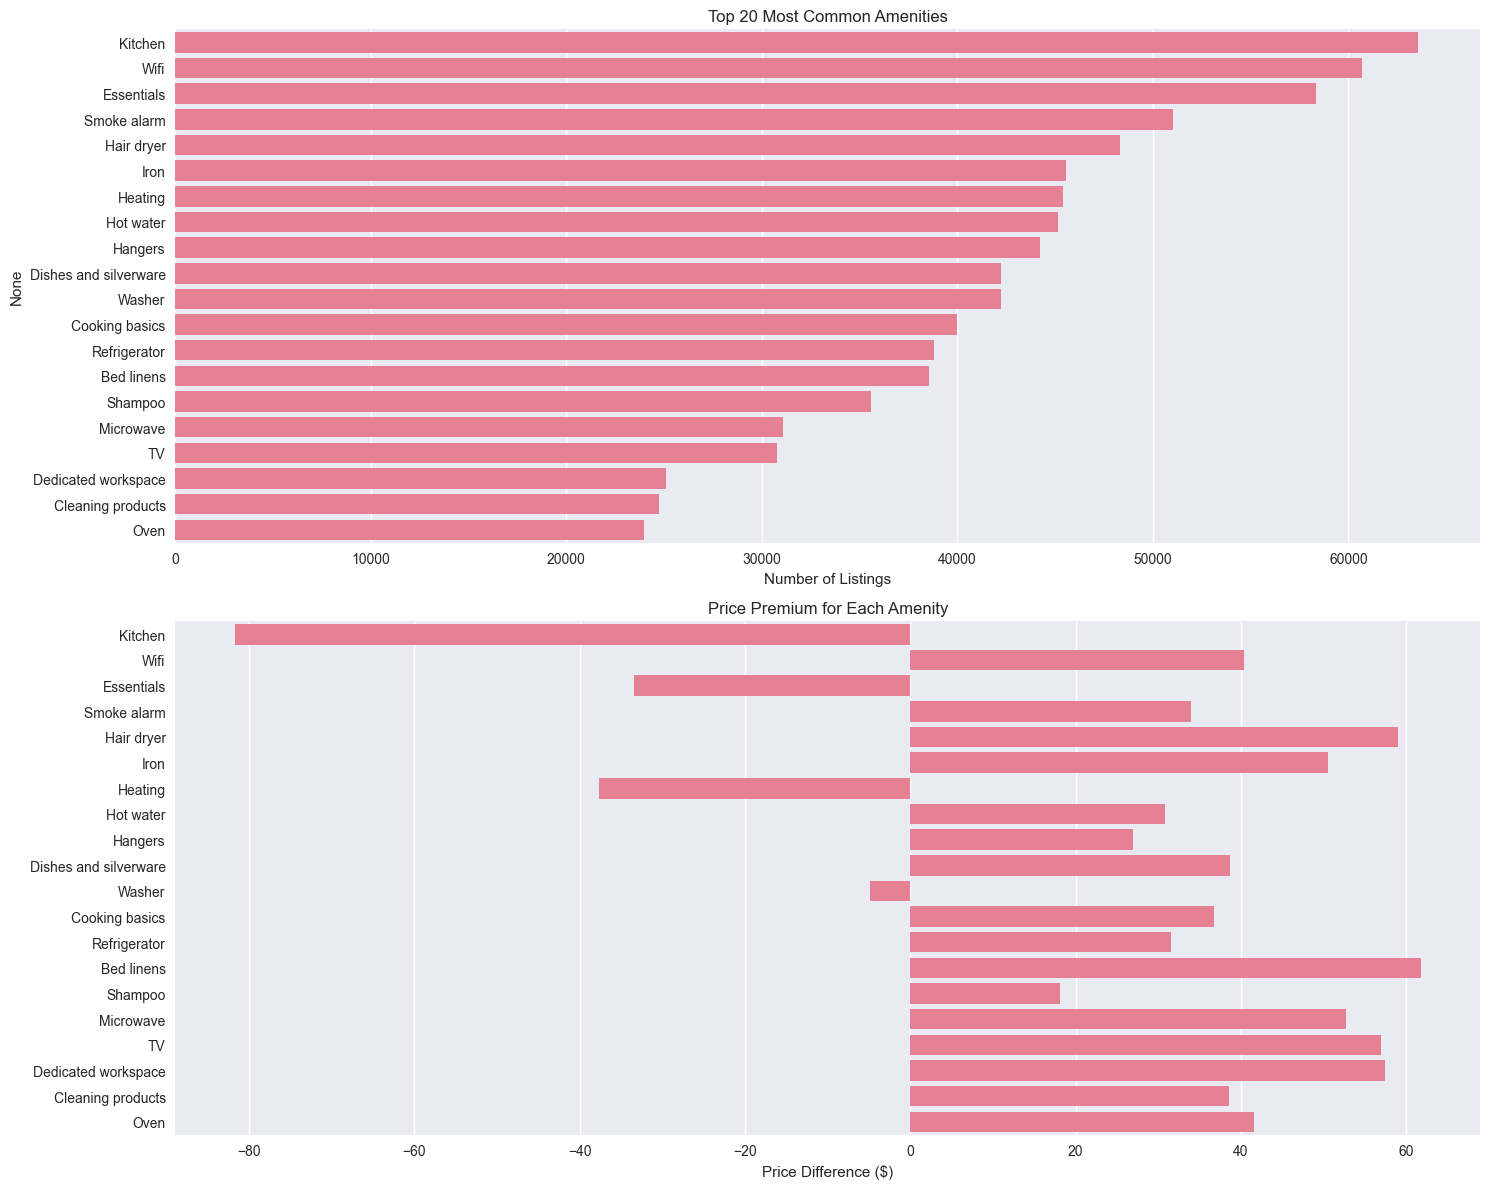

In [10]:
# Example usage - run this in a notebook cell:
city = "paris"
date = "2023-09-04"

# Load data
listings, calendar, neighborhoods = load_city_data(base_folder, city, date)

# Run analyses
print_basic_stats(listings, city, date)
plot_price_distributions(listings, city, date)
plot_neighborhood_analysis(listings)
plot_seasonal_patterns(calendar)
plot_room_type_analysis(listings)
analyze_reviews_ratings(listings)
create_amenities_analysis(listings)

**Preprocessing**

In [11]:
def analyze_amenities(listings):
    """
    First step: Analyze amenities to inform preprocessing decisions
    """
    # Convert string representation to list (if not already done)
    if isinstance(listings['amenities'].iloc[0], str):
        listings['amenities'] = listings['amenities'].apply(eval)
    
    # Count occurrences of each amenity
    amenity_counts = {}
    total_listings = len(listings)
    
    for amenities_list in listings['amenities']:
        for amenity in amenities_list:
            # Clean the amenity string
            clean_amenity = amenity.encode('ascii', 'ignore').decode('ascii')
            amenity_counts[clean_amenity] = amenity_counts.get(clean_amenity, 0) + 1
    
    # Convert to DataFrame for analysis
    amenity_df = pd.DataFrame.from_dict(amenity_counts, orient='index', columns=['count'])
    amenity_df['frequency'] = amenity_df['count'] / total_listings * 100
    amenity_df = amenity_df.sort_values('count', ascending=False)
    
    return amenity_df

def create_amenity_features(listings, amenity_analysis, min_frequency=5):
    """
    Create amenity features based on analysis
    """
    # Get frequent amenities
    frequent_amenities = amenity_analysis[amenity_analysis['frequency'] >= min_frequency].index
    
    # Create features DataFrame
    df_features = pd.DataFrame(index=listings.index)
    
    # 1. Binary features for frequent amenities
    print(f"\nCreating binary features for {len(frequent_amenities)} frequent amenities...")
    for amenity in frequent_amenities:
        col_name = f'amenity_{amenity.lower().replace(" ", "_").replace("-", "_").replace(".", "")}'
        try:
            # Check if amenity exists in the amenities list
            df_features[col_name] = listings['amenities'].apply(
                lambda x: 1 if any(item.strip() == amenity for item in x) else 0
            )
        except Exception as e:
            print(f"Error processing amenity '{amenity}': {str(e)}")
            continue
    
    # 2. Category-based features
    amenity_categories = {
        'wifi': ['wifi', 'internet', 'fast wifi', 'wireless'],
        'tv': ['tv', 'hdtv', 'television', 'netflix', 'cable'],
        'kitchen': ['kitchen', 'cooking', 'stove', 'oven', 'refrigerator', 'microwave'],
        'bathroom': ['bath', 'shower', 'bathroom'],
        'workspace': ['workspace', 'desk', 'laptop friendly'],
        'parking': ['parking', 'garage', 'car'],
        'washer': ['washer', 'laundry', 'dryer'],
        'ac': ['air conditioning', 'ac', 'cooling'],
        'outdoor': ['patio', 'balcony', 'garden', 'terrace', 'backyard']
    }
    
    print("\nCreating category-based features...")
    for category, keywords in amenity_categories.items():
        try:
            df_features[f'has_{category}'] = listings['amenities'].apply(
                lambda x: 1 if any(any(k.lower() in item.lower() for k in keywords) for item in x) else 0
            )
        except Exception as e:
            print(f"Error processing category '{category}': {str(e)}")
            continue
    
    # 3. Count features
    print("\nCreating count features...")
    df_features['amenities_count'] = listings['amenities'].apply(len).astype(int)
    
    # Verify all columns are numeric
    for col in df_features.columns:
        df_features[col] = pd.to_numeric(df_features[col], errors='coerce').fillna(0).astype(int)
    
    return df_features

def handle_missing_values(df):
    """
    Handle missing values and remove columns with remaining missing values
    """
    print("\nHandling missing values...")
    df_clean = df.copy()
    
    # Print initial missing values
    missing = df_clean.isnull().sum()
    missing_pct = (missing / len(df_clean)) * 100
    
    print("\nInitial missing values:")
    for col in missing[missing > 0].index:
        print(f"{col}: {missing[col]} ({missing_pct[col]:.2f}%)")
    
    # 1. Physical attributes (use median for specific property type and room type)
    physical_cols = ['bedrooms', 'beds', 'bathrooms']
    for col in physical_cols:
        # Group by property_type and room_type to get more accurate medians
        medians = df_clean.groupby(['property_type', 'room_type'])[col].transform('median')
        df_clean[col] = df_clean[col].fillna(medians)
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
        print(f"\nFilled {col} missing values using property type and room type medians")
    
    # 2. Review scores (all related columns)
    review_score_cols = [col for col in df_clean.columns if col.startswith('review_scores_')]
    for col in review_score_cols:
        median_score = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_score)
        print(f"Filled {col} missing values with median: {median_score:.2f}")
    
    # 3. Review-related dates and counts
    df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)
    df_clean['has_reviews'] = df_clean['number_of_reviews'].notna() & (df_clean['number_of_reviews'] > 0)
    
    # 4. Drop columns that still have missing values
    missing_after = df_clean.isnull().sum()
    cols_with_missing = missing_after[missing_after > 0].index.tolist()
    
    if cols_with_missing:
        print("\nRemoving columns with remaining missing values:")
        for col in cols_with_missing:
            print(f"{col}: {missing_after[col]} missing values")
        df_clean = df_clean.drop(columns=cols_with_missing)
    
    print(f"\nRemoved {len(cols_with_missing)} columns with missing values")
    print("Final shape:", df_clean.shape)
    
    # Verify no missing values remain
    final_missing = df_clean.isnull().sum().sum()
    if final_missing > 0:
        print(f"\nWarning: {final_missing} missing values still remain")
    else:
        print("\nSuccess: No missing values remain in the dataset")
    
    return df_clean

def preprocess_listings(listings):
    """
    Updated preprocessing function
    """
    print("Starting preprocessing pipeline...")
    df = listings.copy()
    
    # 1. Remove unwanted columns
    columns_to_drop = [
        'listing_url', 'scrape_id', 'last_scraped', 'source', 
        'name', 'description', 'neighborhood_overview', 
        'picture_url', 'neighbourhood', 'neighbourhood_group_cleansed', 
        'calendar_updated', 'license'
    ]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    print(f"\nRemoved {len(columns_to_drop)} unnecessary columns")
    
    # 2. Remove host columns
    host_cols = [col for col in df.columns if col.startswith('host_')]
    df = df.drop(columns=host_cols)
    print(f"Removed {len(host_cols)} host-related columns")
    
    # 3. Handle missing values
    df = handle_missing_values(df)
    
    # # 4. Clean bathroom text
    # df['bathrooms'] = df['bathrooms_text'].fillna('0 bath')
    # df['bathrooms'] = df['bathrooms_text'].str.extract(r'([\d.]+)').astype(float)
    # df = df.drop(columns=['bathrooms_text'])
    
    # 5. Process amenities
    amenity_analysis = analyze_amenities(df)
    print(f"\nFound {len(amenity_analysis)} unique amenities")
    
    amenity_features = create_amenity_features(df, amenity_analysis, min_frequency=5)
    print(f"\nCreated {len(amenity_features.columns)} amenity-related features")
    
    # 6. Combine everything
    df = df.drop(columns=['amenities'])
    df = pd.concat([df, amenity_features], axis=1)
    
    print("\nFinal columns in dataset:")
    print(df.columns.tolist())
    
    return df, amenity_analysis

In [12]:
# Set paths and parameters
base_folder = 'C:\\Users\\mvk\\Documents\\DATA_school\\thesis\\data_new'
output_folder = 'C:\\Users\\mvk\\Documents\\GitHub\\Airbnb-spatiotemporal'
city = "paris"
date = "2023-06-06"

def save_processed_df(df, city, date, output_folder):
    """
    Save the processed DataFrame to CSV in the GitHub folder
    """
    filename = f"{city}_{date}_processed.csv"
    filepath = os.path.join(output_folder, filename)
   
    try:
        df.to_csv(filepath, index=False, encoding='utf-8')
        print(f"\nSuccessfully saved processed data to: {filepath}")
        print(f"File size: {os.path.getsize(filepath) / (1024*1024):.2f} MB")
    except Exception as e:
        print(f"\nError saving file: {str(e)}")
        try:
            df.to_csv(filepath, index=False, encoding='latin1')
            print(f"Successfully saved with alternative encoding to: {filepath}")
        except Exception as e:
            print(f"Failed to save file: {str(e)}")

def analyze_amenity_presence(processed_df):
    """
    Analyze and display amenity presence in the dataset
    """
    print("\nFinal DataFrame Shape:", processed_df.shape)
    print("\nAmenity-related columns created:")
    amenity_cols = [col for col in processed_df.columns if 'amenity_' in col or 'has_' in col]
    
    for col in amenity_cols:
        try:
            col_values = pd.to_numeric(processed_df[col], errors='coerce').fillna(0)
            presence = (col_values.sum() / len(processed_df)) * 100
            print(f"{col}: {presence:.1f}%")
        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")
            print(f"Sample values from {col}:")
            print(processed_df[col].head())

if __name__ == "__main__":
    # Load and process data
    listings, calendar, neighborhoods = load_city_data(base_folder, city, date)
    processed_df, amenity_analysis = preprocess_listings(listings)
    
    # Analyze results
    analyze_amenity_presence(processed_df)
    
    # Save results
    save_processed_df(processed_df, city, date, output_folder)

Starting preprocessing pipeline...

Removed 12 unnecessary columns
Removed 18 host-related columns

Handling missing values...

Initial missing values:
bathrooms: 61706 (100.00%)
bathrooms_text: 99 (0.16%)
bedrooms: 14813 (24.01%)
beds: 728 (1.18%)
minimum_minimum_nights: 3 (0.00%)
maximum_minimum_nights: 3 (0.00%)
minimum_maximum_nights: 3 (0.00%)
maximum_maximum_nights: 3 (0.00%)
minimum_nights_avg_ntm: 3 (0.00%)
maximum_nights_avg_ntm: 3 (0.00%)
first_review: 12281 (19.90%)
last_review: 12281 (19.90%)
review_scores_rating: 12281 (19.90%)
review_scores_accuracy: 12802 (20.75%)
review_scores_cleanliness: 12798 (20.74%)
review_scores_checkin: 12812 (20.76%)
review_scores_communication: 12802 (20.75%)
review_scores_location: 12812 (20.76%)
review_scores_value: 12814 (20.77%)
reviews_per_month: 12281 (19.90%)

Filled bedrooms missing values using property type and room type medians

Filled beds missing values using property type and room type medians

Filled bathrooms missing values usin

c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Found 6586 unique amenities

Creating binary features for 77 frequent amenities...

Creating category-based features...

Creating count features...

Created 87 amenity-related features

Final columns in dataset:
['id', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'price_clean', 'has_rev

Starting preprocessing pipeline...

Removed 12 unnecessary columns
Removed 18 host-related columns

Handling missing values...

Initial missing values:
bathrooms: 61706 (100.00%)
bathrooms_text: 99 (0.16%)
bedrooms: 14813 (24.01%)
beds: 728 (1.18%)
minimum_minimum_nights: 3 (0.00%)
maximum_minimum_nights: 3 (0.00%)
minimum_maximum_nights: 3 (0.00%)
maximum_maximum_nights: 3 (0.00%)
minimum_nights_avg_ntm: 3 (0.00%)
maximum_nights_avg_ntm: 3 (0.00%)
first_review: 12281 (19.90%)
last_review: 12281 (19.90%)
review_scores_rating: 12281 (19.90%)
review_scores_accuracy: 12802 (20.75%)
review_scores_cleanliness: 12798 (20.74%)
review_scores_checkin: 12812 (20.76%)
review_scores_communication: 12802 (20.75%)
review_scores_location: 12812 (20.76%)
review_scores_value: 12814 (20.77%)
reviews_per_month: 12281 (19.90%)

Filled bedrooms missing values using property type and room type medians

Filled beds missing values using property type and room type medians

Filled bathrooms missing values usin

c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Found 6586 unique amenities

Creating binary features for 77 frequent amenities...

Creating category-based features...

Creating count features...

Created 87 amenity-related features

Final columns in dataset:
['id', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'price_clean', 'has_rev

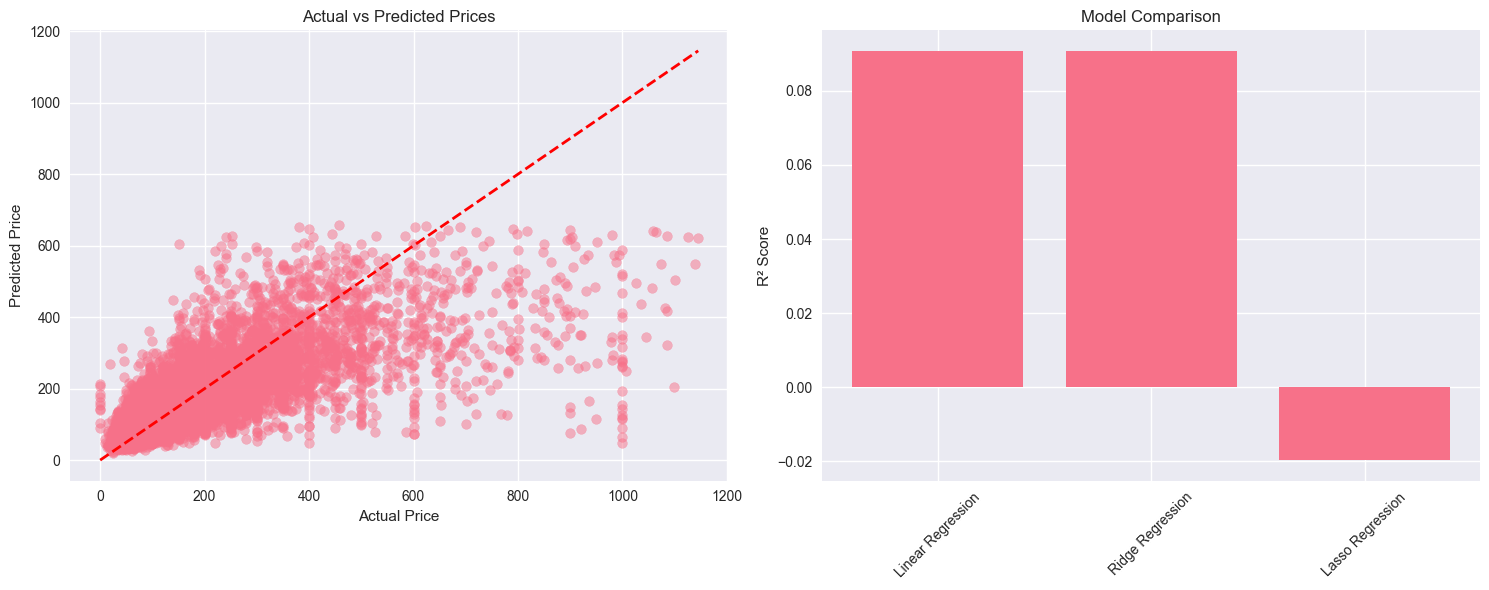

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

def prepare_features(df):
    """
    Prepare features for modeling with improved preprocessing
    """
    # Remove non-feature columns
    cols_to_drop = [
        'id', 'listing_id', 'price', 'first_review', 'last_review',
        'calendar_last_scraped', 'has_availability'
    ]
    
    feature_df = df.copy()
    for col in cols_to_drop:
        if col in feature_df.columns:
            feature_df = feature_df.drop(columns=[col])
    
    # Create dummy variables for categorical columns with handling for rare categories
    categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type']
    
    # Handle rare categories (less than 1% of data)
    for col in categorical_columns:
        value_counts = feature_df[col].value_counts(normalize=True)
        rare_categories = value_counts[value_counts < 0.01].index
        if len(rare_categories) > 0:
            feature_df[col] = feature_df[col].replace(rare_categories, 'Other')
    
    df_encoded = pd.get_dummies(feature_df[categorical_columns], drop_first=True)
    
    # Select numeric columns excluding the target
    numeric_cols = feature_df.select_dtypes(include=['int64', 'float64']).columns
    numeric_cols = numeric_cols.drop('price_clean')  # Remove target variable
    
    # Log transform the target variable
    y = np.log1p(feature_df['price_clean'])
    
    # Combine features
    X = pd.concat([feature_df[numeric_cols], df_encoded], axis=1)
    
    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Number of numeric features: {len(numeric_cols)}")
    print(f"Number of categorical features: {len(df_encoded.columns)}")
    
    return X, y

def train_linear_models(X, y):
    """
    Train and evaluate multiple linear regression models with improvements
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models with better parameters
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=10.0),  # Increased regularization
        'Lasso Regression': Lasso(alpha=1.0)
    }
    
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions and transform back from log scale
        y_pred = model.predict(X_test_scaled)
        y_pred_actual = np.expm1(y_pred)
        y_test_actual = np.expm1(y_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test_actual, y_pred_actual)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_actual, y_pred_actual)
        r2 = r2_score(y_test_actual, y_pred_actual)
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
        
        print(f"\n{name} Performance:")
        print(f"R² Score: {r2:.4f}")
        print(f"RMSE: ${rmse:.2f}")
        print(f"MAE: ${mae:.2f}")
        print(f"Cross-validation R² scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        results[name] = {
            'model': model,
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'cv_scores': cv_scores
        }
        
        if name == 'Linear Regression':
            feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'coefficient': model.coef_
            })
            feature_importance['abs_coefficient'] = abs(feature_importance['coefficient'])
            feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
            
            print("\nTop 10 Most Important Features:")
            print(feature_importance.head(10))
    
    return results, scaler

def plot_regression_results(results, X, y):
    """
    Create visualizations for regression results with better scaling
    """
    # Split data for visualization
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Actual vs Predicted for Linear Regression
    model = results['Linear Regression']['model']
    y_pred = np.expm1(model.predict(X_test_scaled))
    y_test_actual = np.expm1(y_test)
    
    # Remove extreme outliers for better visualization
    mask = (y_test_actual < np.percentile(y_test_actual, 99)) & (y_pred < np.percentile(y_pred, 99))
    
    axes[0].scatter(y_test_actual[mask], y_pred[mask], alpha=0.5)
    axes[0].plot([y_test_actual[mask].min(), y_test_actual[mask].max()], 
                 [y_test_actual[mask].min(), y_test_actual[mask].max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual Price')
    axes[0].set_ylabel('Predicted Price')
    axes[0].set_title('Actual vs Predicted Prices')
    
    # Plot 2: Model Comparison
    model_names = list(results.keys())
    r2_scores = [results[name]['r2'] for name in model_names]
    
    axes[1].bar(model_names, r2_scores)
    axes[1].set_ylabel('R² Score')
    axes[1].set_title('Model Comparison')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load and preprocess data
    city = "paris"
    date = "2023-06-06"
    base_folder = 'C:\\Users\\mvk\\Documents\\DATA_school\\thesis\\data_new'
    
    # Load and preprocess
    listings, calendar, neighborhoods = load_city_data(base_folder, city, date)
    processed_df, _ = preprocess_listings(listings)
    
    # Prepare features
    X, y = prepare_features(processed_df)
    
    # Train and evaluate models
    results, scaler = train_linear_models(X, y)
    
    # Plot results
    plot_regression_results(results, X, y)